In [2]:
import tensorflow as tf
import numpy as np
import cv2
import napari

import matplotlib.pyplot as plt

from cell_division.nets.transfer_learning import CNN
from utils.data.dataset_cell import CellDataset
from utils.data.dataset_nuclei import NucleiDataset
from utils import values as v
from utils.misc import visualizer as vis
from utils.misc.colors import bcolors as bc

from sklearn.metrics import classification_report, confusion_matrix
from cell_division.layers.custom_layers import (
    ExtendedLSEPooling,
    extended_w_cel_loss
)

from cell_division.nets.cam import overlay_heatmap, CAM

# GPU config
from utils.gpu.gpu_tf import (
    increase_gpu_memory, 
    set_gpu_allocator
)
plt.style.use('default')

import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


increase_gpu_memory()
set_gpu_allocator()


In [3]:
img_dir = v.data_path + 'CellDivision/images_nuclei/'
label_train_dir = v.data_path + 'CellDivision/undersampled/train.csv'
label_test_dir = v.data_path + 'CellDivision/undersampled/test.csv'
label_val_dir = v.data_path + 'CellDivision/undersampled/val.csv'

INPUT_SHAPE = (100, 100, 3)
BATCH_SIZE = 32

In [4]:
train_generator = CellDataset(
    img_dir, 
    label_train_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

val_generator = CellDataset(
    img_dir, 
    label_val_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

test_generator = CellDataset(
    img_dir, 
    label_test_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

In [5]:
model = CNN(
    base=tf.keras.applications.VGG16,
    input_shape=INPUT_SHAPE,
    n_classes=3
)
model.build_top(activation='softmax', b_type='CAM', pooling=ExtendedLSEPooling)
model.compile(
    lr=.001,
    loss=extended_w_cel_loss()
)

model.load('../models/cellular_division_models/vgg16_nuclei_under.h5')

In [6]:
from skimage import morphology
from utils.data import imaging
from utils.data.dataset_ht import HtDataset
from filtering import cardiac_region as cr


class NucleiDataset(tf.keras.utils.Sequence):
    def __init__(self, specimen, tissue='myocardium', resize=(50, 50), verbose=1):
        def parse_centroids(centroid):
            centroid = centroid.replace('[', '').replace(']', '').split(',')
            x, y, z = int(centroid[0]), int(centroid[1]), int(centroid[2])
            return np.array([x, y, z])

        self.N_CLASSES = 3
        self.CLASS_NAMES = ['Prophase/Metaphase', 'Anaphase/Telophase', 'Interphase']
        self.CLASSES = ['0', '1', '2']

        self.specimen = specimen

        self.batch_size = 32
        self.resize = (50, 50)

        ds = HtDataset()
        self.features = ds.get_features(specimen, 'Nuclei', tissue, verbose=verbose)
        self.cell_ids = self.features['cell_id']
        centroids = self.features['centroids']
        self.centroids = np.array([parse_centroids(c) for c in centroids])

        self.seg_path, _ = ds.read_specimen(specimen, 'Nuclei', 'Segmentation', verbose=verbose)
        self.raw_path, _ = ds.read_specimen(specimen, 'Nuclei', 'RawImages', verbose=verbose)

        self.seg_img = imaging.read_image(self.seg_path, verbose=verbose)
        self.raw_img = imaging.read_image(self.raw_path, verbose=verbose)

        self.resize = resize

        if verbose:
            print(f'{bc.OKGREEN}Nuclei Dataset created successfully{bc.ENDC}')
            print(f'\t{bc.OKBLUE}Specimen: {bc.ENDC}{self.specimen}')
            print(f'\t{bc.OKBLUE}Tissue: {bc.ENDC}{tissue}')
            print(f'\t{bc.OKBLUE}Number of Nuclei: {bc.ENDC}{len(self.cell_ids)}')

    def __get_image(self, idx):        
        cell_id = self.cell_ids[idx]
        c = self.centroids[idx]

        # Crop cell region + dilatation
        margins = cr.get_cell_margins(self.seg_img, cell_id, ma=0)
        mask = self.seg_img[
            c[0]-25: c[0]+25, c[1]-25: c[1]+25,
            int(margins[0][2]): int(margins[1][2])
        ]
        mask = np.where(mask == cell_id, 255, 0).astype(np.uint8)
        mask_dilated = morphology.opening(mask, morphology.ball(3))

        # Remove empty z-slices
        non_empty_slices = [
            i for i in range(mask.shape[2]) 
            if np.any(mask[..., i])
        ]
        mask = mask[..., non_empty_slices]
        mask_dilated = mask_dilated[..., non_empty_slices]

        # Crop raw image
        img_cell = self.raw_img[
            c[0]-25: c[0]+25, c[1]-25: c[1]+25,
            int(margins[0][2]): int(margins[1][2])
        ]
        img_cell = img_cell[..., non_empty_slices]

        # Erse background
        img_cell_no_bg = np.where(mask_dilated == 0, 0, img_cell)

        # IQR filter ver intensity
        img_cell_no_bg, intensities, thr = imaging.iqr_filter(
            img_cell_no_bg, get_params=True, verbose=1
        )
        mask_dilated = mask_dilated[..., intensities > thr]
        return img_cell_no_bg, mask_dilated

    def __get_cell_id(self, idx):
        return self.cell_ids[idx]

    def __len__(self):
        return len(self.cell_ids)

    def __getitem__(self, item):
        img, mask = self.__get_image(item)
        return (
            img.astype(np.uint8),
            mask.astype(np.uint8),
            self.__get_cell_id(item)
        )

In [7]:
s = '0404_E1'
nuclei = NucleiDataset(s, 'myocardium') 

	Found: 20190404_E1_cell_properties_radiomics_Nuclei_myocardium.csv
	Found: 20190404_E1_mask_all.nii.gz
	Found: 20190404_E1_DAPI_decon_0.5.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr9/Segmentation/Nuclei/20190404_E1_mask_all.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr9/RawImages/Nuclei/20190404_E1_DAPI_decon_0.5.nii.gz
Nuclei Dataset created successfully
	Specimen: 0404_E1
	Tissue: myocardium
	Number of Nuclei: 2232


In [8]:
idx = 100

img, mask, cell_id = nuclei[idx]
print(cell_id, img.shape)

IQR Threshold: 1.7643920000000002
Removing 5 z-slices
7221 (50, 50, 12)


In [9]:
for z in range(img.shape[2]):
    cv2.imshow(str(cell_id), mask[..., z].astype(np.uint8))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [10]:
idx = 250 # 55 100
img, mask, cell_id = nuclei[idx]

IQR Threshold: 0.6741079999999999
Removing 3 z-slices


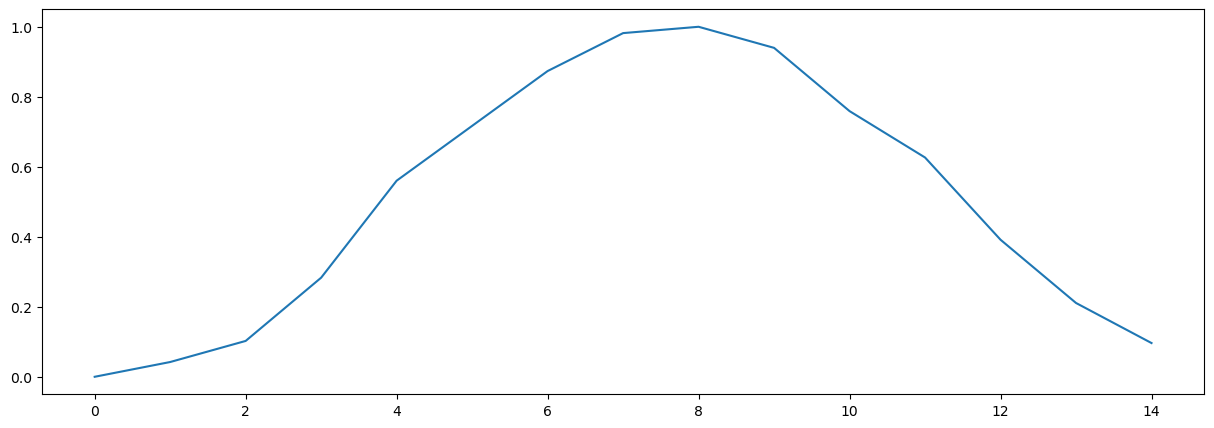

In [14]:
if img.ndim == 3:
    n_slices = img.shape[2]

    plt.figure(figsize=(15, 5))
    img_norm = np.swapaxes(np.swapaxes([
        cv2.normalize(img[..., z], None, 0, 255, cv2.NORM_MINMAX)
        for z in range(n_slices)
    ], 0, 1), 1, 2)
    intensities = np.array([np.mean(img_norm[..., z]) for z in range(n_slices)])
    intensities_norm = (intensities - np.min(intensities)) / (np.max(intensities) - np.min(intensities))
    
    areas = np.array([np.sum(mask[..., z]) for z in range(n_slices)])
    areas_norm = (areas - np.min(areas)) / (np.max(areas) - np.min(areas))
    
    # plt.plot(intensities_norm)
    plt.plot(areas_norm)

In [12]:
idx = 250 # 55 100
img, mask, cell_id = nuclei[idx]

IQR Threshold: 0.6741079999999999
Removing 3 z-slices


In [13]:

if img.ndim == 3:
    n_slices = img.shape[2]
    
    areas = np.array([np.sum(mask[..., z]) for z in range(n_slices)])
    weights = (areas - np.min(areas)) / (np.max(areas) - np.min(areas))
    weights /= np.sum(weights)
    
    preds = []
    for z in range(n_slices):
        aux = cv2.cvtColor(img[..., z], cv2.COLOR_GRAY2RGB)[np.newaxis, ...]
        aux = tf.image.resize(aux, (100, 100))
        preds.append(model.predict_proba(aux)[0])
        
    preds = np.array(preds)

    # Majority voting with weights
    pred = np.sum(preds * weights[:, np.newaxis], axis=0)
    pred = np.argmax(pred)